# Setting up a parcels run

In [1]:
import math
from datetime import timedelta
from glob import glob
from netCDF4 import Dataset
import os
import sys
# import proj

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr

from parcels import (
    AdvectionRK4,
    AdvectionRK4_3D,
    FieldSet,
    JITParticle,
    ParticleSet,
)

In [7]:
input_datasets = {
        # 'input_base_dir': os.path.abspath('/hpcfreenas/hindcast'),
        'input_base_dir': os.path.abspath('/scratch/local1'),
    }

input_datasets['rom'] = {
    'path_to_hindcast': os.path.join(
        input_datasets['input_base_dir'],
        'ROMS/doppio_bay_02' if sys.platform == 'linux' else 'rom'
        ),
    'file_mask': 'doppio_his_201*.nc',
    # 'transformer': proj.Transformer.from_crs(
    #     proj.CRS.from_epsg(4326), # WGS84
    #     proj.CRS.from_epsg(32619), # UTM19N
    #     always_xy=True),
    'data_dt': 3600, # seconds
    'release_points_lon_lat': np.array([
        [-74.8860462 ,  35.44369297],
        [-74.52862058,  34.2950443 ],
        [-74.21067673,  34.67342632],
        [-73.95323861,  35.41533207],
        [-73.46990185,  35.73379049],
        [-73.18779878,  39.79203454],
        [-72.84653146,  38.95630874],
        [-72.63457538,  36.91732252],
        [-72.59191209,  40.63632652],
        [-72.19871125,  35.34782645],
        [-71.16154411,  36.63844384],
        [-70.09004307,  38.54977471],
        [-69.9444851 ,  38.71378714],
        [-69.84821837,  42.92174757],
        [-69.80693744,  40.67720343],
        [-68.10444023,  41.69506538],
        [-67.62495283,  41.95124591],
        [-64.79557692,  42.78925352],
        [-64.51109065,  43.15402752],
        [-64.26535265,  39.81402787],
        [-63.43641926,  41.95324376],
        [-63.04835776,  43.70211662],
        [-62.37610229,  41.41986588],
        [-61.84710945,  43.14830997],
        [-61.12644699,  42.29980774],
        ])
}

# nemo
input_datasets['nemo'] = {
    # https://data.marine.copernicus.eu/product/BALTICSEA_ANALYSISFORECAST_PHY_003_006/description
    'path_to_hindcast': os.path.join(
        input_datasets['input_base_dir'],
        'NEMO/baltic'
        ),
    'file_mask': 'BAL-NEMO_PHY*.nc',
    'oceantracker_reader': "GLORYSreader",
    # 'transformer': proj.Transformer.from_crs(
    #     proj.CRS.from_epsg(4326), # WGS84
    #     proj.CRS.from_epsg(25833), # UTM33N
    #     always_xy=True),
    'data_dt': 3600, # seconds
    'release_points_lon_lat': np.array([
       [53.62084284, 26.24914652],
       [57.59627221, 11.74138304],
       [59.12949598,  9.88378601],
       [65.19897143, 30.07541881],
       [62.96581345, 29.32377253],
       [58.95689007, 26.87092123],
       [60.57033272, 12.9142767 ],
       [64.97765214, 20.37102819],
       [54.51054369, 16.58614791],
       [55.17697955, 24.33259039],
       [65.39135172, 17.12729343],
       [58.59563195, 14.47562539],
       [59.74996876, 20.20060957],
       [60.0049921 , 29.64630312],
       [61.24584975, 27.97088661],
       [64.49986076, 18.72113521],
       [63.30012739, 25.87274585],
       [54.66695745, 23.78606984],
       [63.85069136, 12.6943194 ],
       [58.13458354,  9.76358744],
       [64.72921574, 22.13668526],
       [55.82292027, 10.69347143],
       [61.26535891, 20.84116893],
       [55.81779955, 17.77054849],
       [56.27449169, 24.98133566],
       [60.48023759, 23.39046898],
       [56.55853394, 23.4398047 ],
       [62.51457639, 23.78187299],
       [57.47840608, 20.05361609],
       [64.28547982, 28.98996948],
       [61.32635904, 10.10919548],
       [54.1708471 , 24.19031533],
       [61.32829611, 26.40140448],
       [53.65127282, 25.54562022],
       [65.31829057, 14.40421594],
       [59.43119579,  9.2518973 ],
       [65.0992816 , 12.30778475],
       [65.07813115, 20.31473819],
       [60.61403735, 22.50382744],
       [54.0901189 , 10.3043585 ],
       [59.50471693,  9.51512965],
       [57.00587859, 26.93017637],
       [64.98688646, 16.01582867],
       [53.04142688, 21.9730505 ],
       [60.22205362, 13.03814926],
       [62.89193372, 21.25043432],
       [53.26718728, 12.0119608 ],
       [64.55376803, 14.58322502],
       [60.19343954, 29.0980035 ],
       [58.54594291, 14.32357401],
       [62.56058157, 13.98202673],
       [59.07419981, 18.42672139],
       [58.40757781, 22.92160067],
       [56.18387909, 26.4437626 ],
       [56.47032963, 10.12816704],
       [64.89123504, 23.09771864],
       [56.35802252,  9.52311737],
       [62.10073175, 29.80705046],
       [61.9760859 , 23.7109601 ],
       [55.88447092, 27.87637301],
       [61.85288612, 21.80402033],
       [65.85533258, 29.45494647],
       [65.83180129, 22.10928   ],
       [53.49512302, 12.12158387],
       [64.58516187, 16.34748407],
       [62.7898229 ,  9.30800596],
       [64.89349194, 12.11301009],
       [64.21230108, 17.61232748],
       [60.06257972, 29.04126983],
       [57.97406794, 24.5017151 ],
       [60.10855417, 29.54677046],
       [53.81078658, 29.80026015],
       [62.43231982, 13.83719405],
       [55.04296726, 19.37098533],
       [57.23093633, 23.23097662],
       [60.95951598, 17.82514458],
       [64.4330012 , 14.26574186],
       [60.03124578, 20.13955352],
       [62.82249405, 22.34704596],
       [54.32750541,  9.59590374],
       [53.32144549, 26.62605371],
       [59.72888189, 19.42698402],
       [65.88918299, 23.69569003],
       [64.89359854, 19.41817545],
       [64.54442435, 27.24574031],
       [62.49514647,  9.68367516],
       [53.02547037, 12.27649651],
       [58.85356371, 18.35921062],
       [64.69341211, 25.45383071],
       [64.62462962, 11.26920642],
       [63.8171803 , 25.96483714],
       [53.74623991, 25.93822683],
       [62.30724119, 23.17364333],
       [54.49405813, 25.87616216],
       [54.47286945, 22.9014177 ],
       [61.79499172, 17.19735258],
       [56.8110667 , 27.66977568],
       [55.27120699, 14.02660348],
       [55.04731439, 18.76514729],
       [62.83521552, 16.65355381]])
}

## NEMO

### example

In [3]:
import parcels
example_dataset_folder = parcels.download_example_dataset(
    "NemoNorthSeaORCA025-N006_data"
)
example_dataset_folder

PosixPath('/home/zmaw/u301513/.cache/parcels/NemoNorthSeaORCA025-N006_data')

In [16]:
ufiles = sorted(glob(f"{example_dataset_folder}/ORCA*U.nc"))
vfiles = sorted(glob(f"{example_dataset_folder}/ORCA*V.nc"))
wfiles = sorted(glob(f"{example_dataset_folder}/ORCA*W.nc"))
# tfiles = sorted(glob(f"{example_dataset_folder}/ORCA*T.nc"))  # Not used in this example
mesh_mask = f"{example_dataset_folder}/coordinates.nc"

'/home/zmaw/u301513/.cache/parcels/NemoNorthSeaORCA025-N006_data/coordinates.nc'

In [18]:
df = Dataset(ufiles[0])
print(df.variables.keys())
df = Dataset(mesh_mask)
print(df.variables.keys())

dict_keys(['depthu', 'nav_lat', 'nav_lon', 'tauuo', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'uo', 'uos'])
dict_keys(['e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'glamf', 'glamt', 'glamu', 'glamv', 'gphif', 'gphit', 'gphiu', 'gphiv', 'nav_lat', 'nav_lev', 'nav_lon', 'time', 'time_steps'])


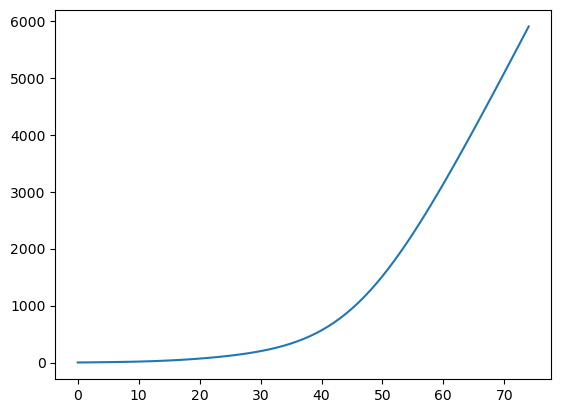

In [24]:
df = Dataset(ufiles[0])
plt.plot(df.variables['depthu'][:])

### baltic sea data set

#### downloading data

In [1]:
base_url = "https://s3.waw3-1.cloudferro.com/mdl-native-11/native/BALTICSEA_ANALYSISFORECAST_PHY_003_006/cmems_mod_bal_phy_anfc_PT1H-i_202311/2021/11/BAL-NEMO_PHY-"

urls_to_fetch = []

for year in ["2021",]:
    for month in ["11",]:
        for day in [f"{i:02d}" for i in range(1, 12)]:
            for hour in ["00","12",]:
                url = base_url+year+month+day+hour+'.nc'
                print(url)

# wget -i file.txt

https://s3.waw3-1.cloudferro.com/mdl-native-11/native/BALTICSEA_ANALYSISFORECAST_PHY_003_006/cmems_mod_bal_phy_anfc_PT1H-i_202311/2021/11/BAL-NEMO_PHY-2021110100.nc
https://s3.waw3-1.cloudferro.com/mdl-native-11/native/BALTICSEA_ANALYSISFORECAST_PHY_003_006/cmems_mod_bal_phy_anfc_PT1H-i_202311/2021/11/BAL-NEMO_PHY-2021110112.nc
https://s3.waw3-1.cloudferro.com/mdl-native-11/native/BALTICSEA_ANALYSISFORECAST_PHY_003_006/cmems_mod_bal_phy_anfc_PT1H-i_202311/2021/11/BAL-NEMO_PHY-2021110200.nc
https://s3.waw3-1.cloudferro.com/mdl-native-11/native/BALTICSEA_ANALYSISFORECAST_PHY_003_006/cmems_mod_bal_phy_anfc_PT1H-i_202311/2021/11/BAL-NEMO_PHY-2021110212.nc
https://s3.waw3-1.cloudferro.com/mdl-native-11/native/BALTICSEA_ANALYSISFORECAST_PHY_003_006/cmems_mod_bal_phy_anfc_PT1H-i_202311/2021/11/BAL-NEMO_PHY-2021110300.nc
https://s3.waw3-1.cloudferro.com/mdl-native-11/native/BALTICSEA_ANALYSISFORECAST_PHY_003_006/cmems_mod_bal_phy_anfc_PT1H-i_202311/2021/11/BAL-NEMO_PHY-2021110312.nc
https://s3

#### testing data

In [3]:
uvw_files = sorted(glob(os.path.join(input_datasets['nemo']['path_to_hindcast'],'*PHY*.nc')))
print(uvw_files)
print(Dataset(uvw_files[0]).variables.keys())

['/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110100.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110112.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110200.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110212.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110300.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110312.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110400.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110412.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110500.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110512.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110600.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110612.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110700.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110712.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110800.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110812.nc', '/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110900.nc', '/scratch/loc

In [4]:
# uvw_files = uvw_files[0]

In [5]:
mesh_mask = glob(os.path.join(input_datasets['nemo']['path_to_hindcast'],'*coordinates.nc'))


In [6]:
lat = df.variables['latitude'][:]
lon = df.variables['longitude'][:]
depth = df.variables['deptho'][:]

# Create the plot
plt.figure(figsize=(12, 6))
plt.contourf(lon, lat, depth, cmap='viridis')
plt.colorbar(label='Depth (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Depth from NEMO Model')
plt.show()

NameError: name 'df' is not defined

In [8]:
filenames = {
    "U": {"lon": uvw_files[0],
          "lat": uvw_files[0],
          "depth": uvw_files[0],
          "data": uvw_files
          },
    "V": {"lon": uvw_files[0],
          "lat": uvw_files[0],
          "depth": uvw_files[0],
          "data": uvw_files
          },
    "W": {"lon": uvw_files[0],
          "lat": uvw_files[0],
          "depth": uvw_files[0],
          "data": uvw_files
          }
}
variables = {
    "U": "uo",
    "V": "vo",
    "W": "wo",
    # "T": "thetao",  # Not used in this example
}

c_grid_dimensions = {
    "lon": "lon",
    "lat": "lat",
    "depth": "depth",
    "time": "time",
}

dimensions = {
    "U": c_grid_dimensions,
    "V": c_grid_dimensions,
    "W": c_grid_dimensions,
    # "T": c_grid_dimensions,  # Not used in this example
}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

In [9]:
pset = ParticleSet(fieldset, JITParticle,
                   lat=input_datasets['nemo']['release_points_lon_lat'][:,0],
                   lon=input_datasets['nemo']['release_points_lon_lat'][:,1],
                   depth=[1]*len(input_datasets['nemo']['release_points_lon_lat'][:,0]))

In [10]:
dt = int(3600*12)
pfile = pset.ParticleFile("SwashParticles", outputdt=timedelta(seconds=dt))

pset.execute(AdvectionRK4_3D, runtime=timedelta(days=2), dt=timedelta(seconds=dt), output_file=pfile)

INFO: Output files are stored in SwashParticles.zarr.
100%|██████████| 172800.0/172800.0 [01:21<00:00, 2133.04it/s]


Level[5] depth is: [5.8002 6.95905]


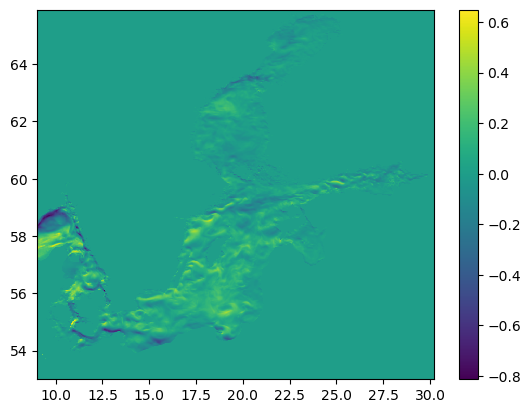

In [58]:
depth_level = 5
print(
    f"Level[{int(depth_level)}] depth is: "
    f"[{fieldset.W.grid.depth[depth_level]:g} "
    f"{fieldset.W.grid.depth[depth_level+1]:g}]"
)

plt.pcolormesh(
    fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, depth_level, :, :]
)
plt.colorbar()
plt.show()

In [30]:
ds = xr.open_zarr('SwashParticles.zarr')

In [31]:
ds

<xarray.Dataset> Size: 14kB
Dimensions:     (trajectory: 100, obs: 4)
Coordinates:
  * obs         (obs) int32 16B 0 1 2 3
  * trajectory  (trajectory) int64 800B 500 501 502 503 504 ... 596 597 598 599
Data variables:
    lat         (trajectory, obs) float64 3kB dask.array<chunksize=(100, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 3kB dask.array<chunksize=(100, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 3kB dask.array<chunksize=(100, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 3kB dask.array<chunksize=(100, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3D
    parcels_mesh:           spherical
    parcels_version:        3.0.4

/home/zmaw/u301513/.conda/envs/parcels/lib/python3.12/site-packages/trajan/plot/__init__.py:159: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num = self.ds.dims['trajectory']


 57%|█████▋    | 489600.0/860400.0 [10:03<07:37, 811.13it/s] 
 24%|██▍       | 205200.0/860400.0 [04:49<15:23, 709.72it/s] 


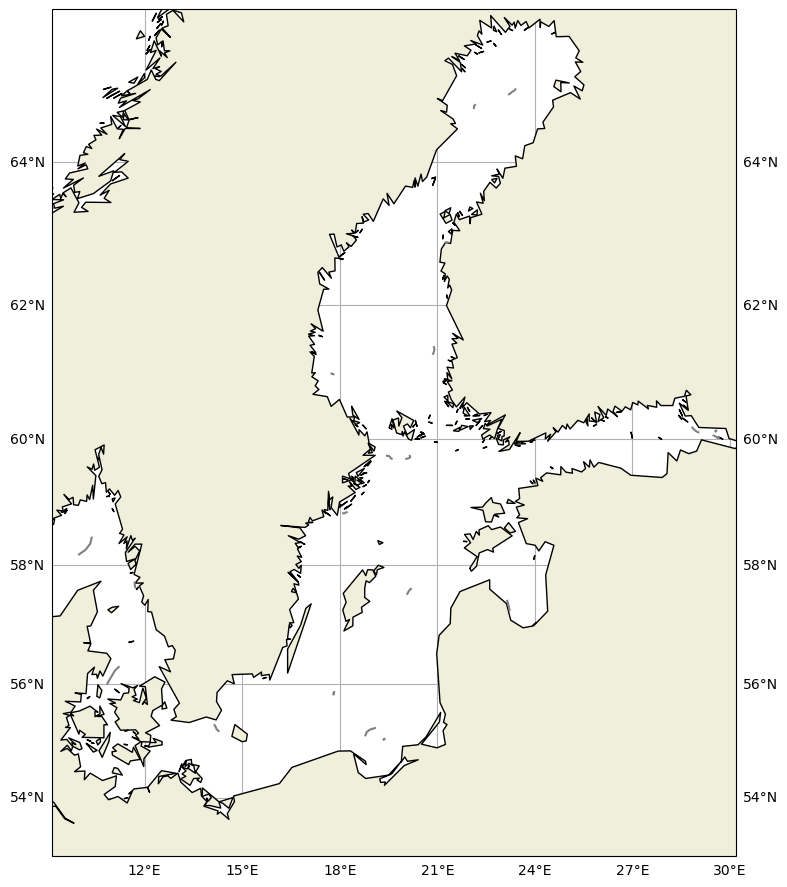

In [29]:
ds = xr.open_zarr('SwashParticles.zarr')

ds.traj.plot()
plt.show()

## ROMS

In [6]:
files = glob(os.path.join(input_datasets['rom']['path_to_hindcast'],input_datasets['rom']['file_mask']))
files = sorted(files)
files = files[:1]

In [ ]:
files

['/scratch/local1/NEMO/baltic/BAL-NEMO_PHY-2021110100.nc']

In [ ]:
# fix time stamps as parcels doesn't handle them 
timestamps = []
for ii,item in enumerate(files):
    df = Dataset(item)
    time = df.variables['ocean_time']

    base_date = np.datetime64('2006-01-01T00:00:00')
    timedeltas = time[:].astype('timedelta64[s]')
    timestamps_file = base_date + timedeltas

    # timestamps = np.concatenate((timestamps, timestamps_file))
    timestamps.append(timestamps_file)

    df.close()

timestamps = np.array(timestamps)


    
    # if ii > 2: break

KeyError: 'ocean_time'

In [ ]:
timestamps

array([['2018-01-01T00:00:00', '2018-01-01T01:00:00',
        '2018-01-01T02:00:00', '2018-01-01T03:00:00',
        '2018-01-01T04:00:00', '2018-01-01T05:00:00',
        '2018-01-01T06:00:00', '2018-01-01T07:00:00',
        '2018-01-01T08:00:00', '2018-01-01T09:00:00',
        '2018-01-01T10:00:00', '2018-01-01T11:00:00',
        '2018-01-01T12:00:00', '2018-01-01T13:00:00',
        '2018-01-01T14:00:00', '2018-01-01T15:00:00',
        '2018-01-01T16:00:00', '2018-01-01T17:00:00',
        '2018-01-01T18:00:00', '2018-01-01T19:00:00',
        '2018-01-01T20:00:00', '2018-01-01T21:00:00',
        '2018-01-01T22:00:00', '2018-01-01T23:00:00',
        '2018-01-02T00:00:00']], dtype='datetime64[s]')

In [ ]:
timestamps.shape

(1, 25)

In [ ]:

# Save to a text file
np.savetxt('timestamps_of_doppio_first_1d.txt', timestamps.astype(str), fmt='%s')
timestamps = np.loadtxt('timestamps_of_doppio_first_1d.txt', dtype='datetime64[s]')
timestamps = np.array([timestamps,])
timestamps

array([['2018-01-01T00:00:00', '2018-01-01T01:00:00',
        '2018-01-01T02:00:00', '2018-01-01T03:00:00',
        '2018-01-01T04:00:00', '2018-01-01T05:00:00',
        '2018-01-01T06:00:00', '2018-01-01T07:00:00',
        '2018-01-01T08:00:00', '2018-01-01T09:00:00',
        '2018-01-01T10:00:00', '2018-01-01T11:00:00',
        '2018-01-01T12:00:00', '2018-01-01T13:00:00',
        '2018-01-01T14:00:00', '2018-01-01T15:00:00',
        '2018-01-01T16:00:00', '2018-01-01T17:00:00',
        '2018-01-01T18:00:00', '2018-01-01T19:00:00',
        '2018-01-01T20:00:00', '2018-01-01T21:00:00',
        '2018-01-01T22:00:00', '2018-01-01T23:00:00',
        '2018-01-02T00:00:00']], dtype='datetime64[s]')

In [ ]:
fieldset = FieldSet.from_netcdf(
    filenames = files,
    variables = {
        'U': 'u',
        'V': 'v',
        'W': 'w',
        },
    dimensions = {
        'U': {'lon': 'lon_u', 'lat': 'lat_u', 'depth': 'not_yet_set'},
        'V': {'lon': 'lon_v', 'lat': 'lat_v', 'depth': 'not_yet_set'},
        'W': {'lon': 'lon_rho', 'lat': 'lat_rho', 'depth': 'not_yet_set'},
    },
    timestamps = list(timestamps),
    deferred_load = False,
    allow_time_extrapolation=False,
    time_periodic = timedelta(hours=24)
)

fieldset.U.set_depth_from_field(grid['layer_boundary_depth'])

AttributeError: 'MaskedArray' object has no attribute 'grid'

In [ ]:
from datetime import timedelta as delta
from glob import glob

import matplotlib.pyplot as plt
import xarray as xr

from parcels import (
    AdvectionRK4_3D,
    FieldSet,
    JITParticle,
    ParticleSet,
    XarrayDecodedFilter,
    download_example_dataset,
    logger,
)

# Add a filter for the xarray decoding warning
logger.addFilter(XarrayDecodedFilter())

example_dataset_folder = download_example_dataset("NemoNorthSeaORCA025-N006_data")
ufiles = sorted(glob(f"{example_dataset_folder}/ORCA*U.nc"))
vfiles = sorted(glob(f"{example_dataset_folder}/ORCA*V.nc"))
wfiles = sorted(glob(f"{example_dataset_folder}/ORCA*W.nc"))
mesh_mask = f"{example_dataset_folder}/coordinates.nc"

filenames = {
    "U": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": ufiles},
    "V": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": vfiles},
    "W": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": wfiles},
}

variables = {"U": "uo", "V": "vo", "W": "wo"}

# Note that all variables need the same dimensions in a C-Grid
c_grid_dimensions = {
    "lon": "glamf",
    "lat": "gphif",
    "depth": "depthw",
    "time": "time_counter",
}
dimensions = {
    "U": c_grid_dimensions,
    "V": c_grid_dimensions,
    "W": c_grid_dimensions,
}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions)


In [ ]:
fieldset

In [ ]:
from netCDF4 import Dataset
df = Dataset(wfiles[0])

In [ ]:
df.variables.keys()

dict_keys(['depthw', 'difvho', 'nav_lat', 'nav_lon', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'wo'])

In [ ]:
df.variables['depthw']

<class 'netCDF4._netCDF4.Variable'>
float32 depthw(depthw)
    long_name: Vertical W levels
    units: m
    axis: Z
    positive: down
unlimited dimensions: 
current shape = (75,)
filling on, default _FillValue of 9.969209968386869e+36 used

### Time varying

In [ ]:
from datetime import timedelta as delta
from os import path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleFile,
    ParticleSet,
    download_example_dataset,
)

In [ ]:
example_dataset_folder = download_example_dataset("SWASH_data")
filenames = f"{example_dataset_folder}/field_*.nc"
variables = {
    "U": "cross-shore velocity",
    "V": "along-shore velocity",
    "depth_u": "time varying depth_u",
}

In [ ]:
dimensions = {
    "U": {"lon": "x", "lat": "y", "depth": "not_yet_set", "time": "t"},
    "V": {"lon": "x", "lat": "y", "depth": "not_yet_set", "time": "t"},
    "depth_u": {"lon": "x", "lat": "y", "depth": "not_yet_set", "time": "t"},
}

In [ ]:
glob(f"{example_dataset_folder}/field_*.nc")[0]

'/home/zmaw/u301513/.cache/parcels/SWASH_data/field_0065557.nc'

In [ ]:
from netCDF4 import Dataset
df = Dataset(glob(f"{example_dataset_folder}/field_*.nc")[0])
df.variables.keys()

dict_keys(['along-shore velocity', 'bot', 'brkp', 'cross-shore velocity', 'eta', 't', 'time varying depth', 'time varying depth_u', 'vertical velocity', 'visc', 'x', 'y', 'z', 'z_u'])

In [ ]:
df.variables['time varying depth'].shape

(1, 7, 21, 51)

In [ ]:
df.variables['time varying depth_u'].shape


(1, 6, 21, 51)

In [ ]:
df.variables['z'].shape

(7,)

In [ ]:
df.variables['z_u'].shape

(6,)

In [ ]:
np.max(df.variables['time varying depth'])

np.float64(0.026437601074576378)

In [ ]:


fieldset = FieldSet.from_netcdf(
    filenames, variables, dimensions, mesh="flat", allow_time_extrapolation=True,
)
fieldset.U.set_depth_from_field(fieldset.depth_u)
fieldset.V.set_depth_from_field(fieldset.depth_u)

In [ ]:
pset = ParticleSet(fieldset, JITParticle, lon=9.5, lat=12.5, depth=-0.1)

pfile = pset.ParticleFile("SwashParticles", outputdt=delta(seconds=0.05))

pset.execute(AdvectionRK4, dt=delta(seconds=0.005), output_file=pfile)

INFO: Output files are stored in SwashParticles.zarr.
100%|██████████| 0.25/0.25 [00:02<00:00,  9.59s/it]               


In [ ]:
dir(fieldset)

['U',
 'UV',
 'V',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_UVfield',
 'add_constant',
 'add_constant_field',
 'add_field',
 'add_periodic_halo',
 'add_vector_field',
 'check_complete',
 'checkvaliddimensionsdict',
 'completed',
 'computeTimeChunk',
 'compute_on_defer',
 'depth_u',
 'from_b_grid_dataset',
 'from_c_grid_dataset',
 'from_data',
 'from_mitgcm',
 'from_modulefile',
 'from_mom5',
 'from_nemo',
 'from_netcdf',
 'from_parcels',
 'from_pop',
 'from_xarray_dataset',
 'get_fields',
 'gridset',
 'parse_wildcards',
 'particlefile',
 'time_origin',
 'write']

In [ ]:
pset.getPType

False

In [ ]:
%matplotlib inline

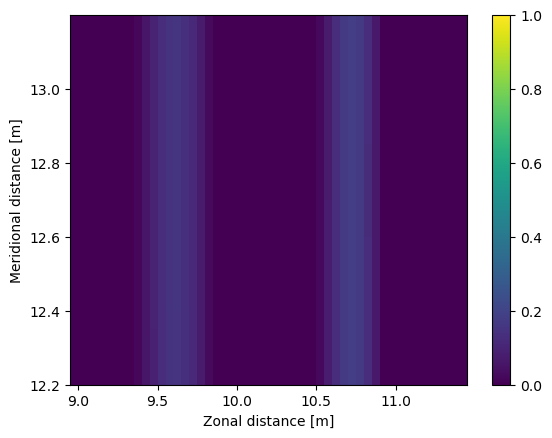

In [ ]:
# fieldset.computeTimeChunk()

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0,1,:-1,:-1],vmin = 0,vmax = 1)
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

# plt.plot(pset.lon, pset.lat, "ko")
plt.show()

In [ ]:

output_file = pset.ParticleFile(
    name="test.zarr",  # the file name
    outputdt=timedelta(days=1),  # the time step of the outputs
)
pset.execute(
    AdvectionRK4_3D,  # the kernel (which defines how particles move)
    runtime=timedelta(days=1),  # the total length of the run
    dt=timedelta(minutes=5),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Output files are stored in test.zarr.


FieldOutOfBoundSurfaceError: Field sampled out-of-bound at the surface, at (-72.59191131591797, 40.63632583618164, -1.0)

/home/zmaw/u301513/.conda/envs/parcels/lib/python3.12/site-packages/trajan/plot/__init__.py:159: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num = self.ds.dims['trajectory']


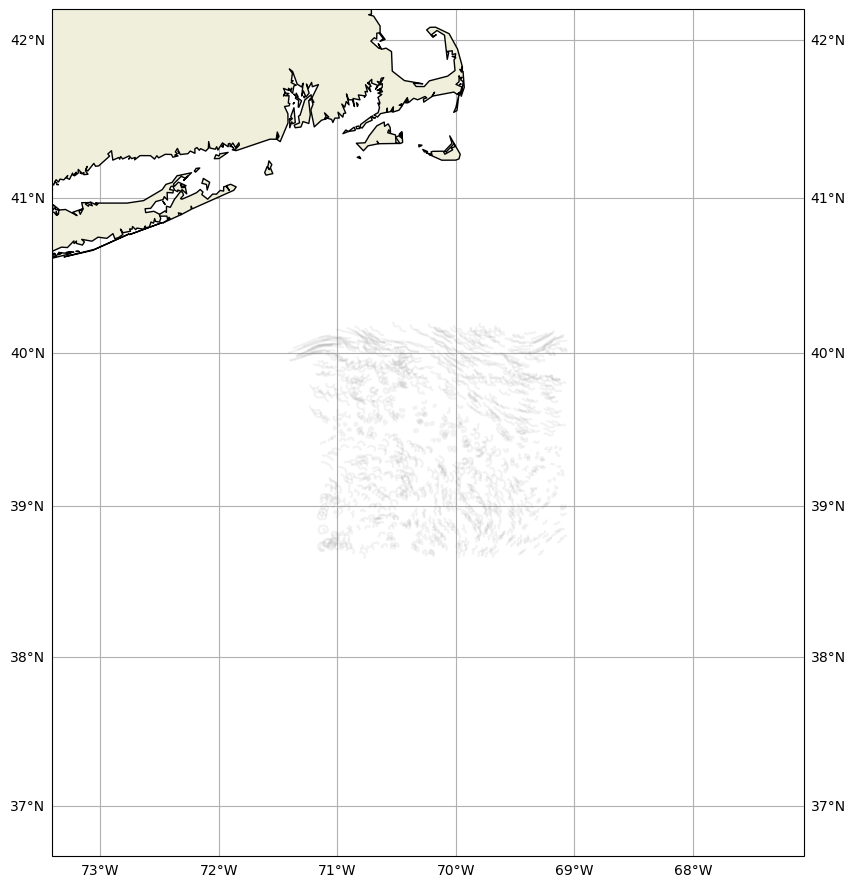

In [ ]:
ds = xr.open_zarr("test.zarr")
ds.traj.plot(margin=2)
plt.show()

In [ ]:
timestamps

array(['2018-01-01T00:00:00'], dtype='datetime64[s]')

In [ ]:
ds

<xarray.Dataset> Size: 488kB
Dimensions:     (trajectory: 1000, obs: 24)
Coordinates:
  * obs         (obs) int32 96B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * trajectory  (trajectory) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    lat         (trajectory, obs) float32 96kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    lon         (trajectory, obs) float32 96kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] 192kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
    z           (trajectory, obs) float32 96kB dask.array<chunksize=(1000, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        3.0.4

### time order bug in later files

In [ ]:
# each data file contains 25h (both midnights) which upsets parcels.
# need to clean data beforehand

### trying some regridding

In [ ]:
import os
import sys 
from glob import glob
import xarray as xr
import xgcm
import numpy as np
from datetime import timedelta as delta
from parcels import (
    AdvectionRK4,
    AdvectionRK4_3D,
    FieldSet,
    JITParticle,
    ParticleSet,
)

In [ ]:
input_datasets = {
        # 'input_base_dir': os.path.abspath('/hpcfreenas/hindcast'),
        'input_base_dir': os.path.abspath('/scratch/local1'),
    }

input_datasets['rom'] = {
    'path_to_hindcast': os.path.join(
        input_datasets['input_base_dir'],
        'ROMS/doppio_bay_02' if sys.platform == 'linux' else 'rom'
        ),
    'file_mask': 'doppio_his_201*.nc',
    # 'transformer': proj.Transformer.from_crs(
    #     proj.CRS.from_epsg(4326), # WGS84
    #     proj.CRS.from_epsg(32619), # UTM19N
    #     always_xy=True),
    'data_dt': 3600, # seconds
    'release_points_lon_lat': np.array([
        [-74.8860462 ,  35.44369297],
        [-74.52862058,  34.2950443 ],
        [-74.21067673,  34.67342632],
        [-73.95323861,  35.41533207],
        [-73.46990185,  35.73379049],
        [-73.18779878,  39.79203454],
        [-72.84653146,  38.95630874],
        [-72.63457538,  36.91732252],
        [-72.59191209,  40.63632652],
        [-72.19871125,  35.34782645],
        [-71.16154411,  36.63844384],
        [-70.09004307,  38.54977471],
        [-69.9444851 ,  38.71378714],
        [-69.84821837,  42.92174757],
        [-69.80693744,  40.67720343],
        [-68.10444023,  41.69506538],
        [-67.62495283,  41.95124591],
        [-64.79557692,  42.78925352],
        [-64.51109065,  43.15402752],
        [-64.26535265,  39.81402787],
        [-63.43641926,  41.95324376],
        [-63.04835776,  43.70211662],
        [-62.37610229,  41.41986588],
        [-61.84710945,  43.14830997],
        [-61.12644699,  42.29980774],
        ])
}

In [ ]:
files = glob(os.path.join(input_datasets['rom']['path_to_hindcast'],input_datasets['rom']['file_mask']))
files = sorted(files)
# files = files[:1]
files

['/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180101_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180102_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180103_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180104_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180105_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180106_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180107_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180108_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180109_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180110_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180111_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180112_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180113_0000_0001.nc',
 '/scratch/local1/ROMS/doppio_bay_02/doppio_his_20180114_0000_00

In [ ]:
import matplotlib.pyplot as plt

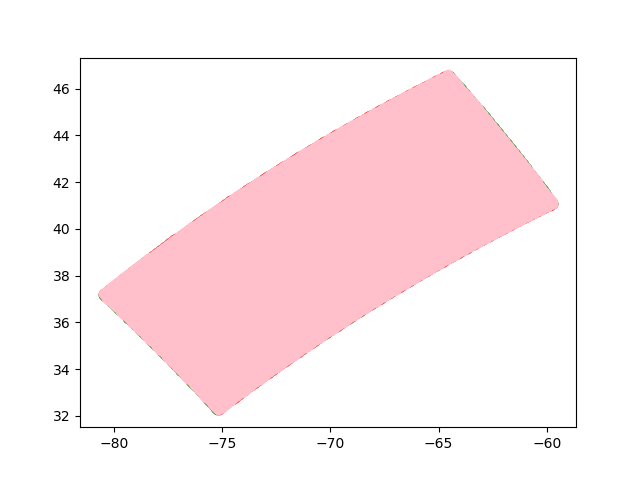

In [ ]:
%matplotlib widget
plt.scatter(ds.lon_u,ds.lat_u,color = 'red')
plt.scatter(ds.lon_v,ds.lat_v,color = 'green')
plt.scatter(ds.lon_psi,ds.lat_psi,color = 'orange')
plt.scatter(ds.lon_rho,ds.lat_rho,color = 'pink')

In [ ]:
ds = xr.open_mfdataset(files, chunks={'ocean_time': 12}, combine="by_coords", parallel=True, decode_times = False)

# remove dublicate midnight entries
all_indices = np.arange(ds.sizes['ocean_time'])
indices_to_keep = all_indices[all_indices % 25 != 0] 
ds = ds.isel(ocean_time=indices_to_keep)

ds

<xarray.Dataset> Size: 53GB
Dimensions:         (ocean_time: 744, tracer: 2, boundary: 4, s_rho: 40,
                     s_w: 41, eta_rho: 106, xi_rho: 242, eta_u: 106, xi_u: 241,
                     eta_v: 105, xi_v: 242, eta_psi: 105, xi_psi: 241)
Coordinates:
  * s_rho           (s_rho) float64 320B -0.9875 -0.9625 ... -0.0375 -0.0125
  * s_w             (s_w) float64 328B -1.0 -0.975 -0.95 ... -0.05 -0.025 0.0
    lon_rho         (eta_rho, xi_rho) float64 205kB dask.array<chunksize=(106, 242), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 205kB dask.array<chunksize=(106, 242), meta=np.ndarray>
    lon_u           (eta_u, xi_u) float64 204kB dask.array<chunksize=(106, 241), meta=np.ndarray>
    lat_u           (eta_u, xi_u) float64 204kB dask.array<chunksize=(106, 241), meta=np.ndarray>
    lon_v           (eta_v, xi_v) float64 203kB dask.array<chunksize=(105, 242), meta=np.ndarray>
    lat_v           (eta_v, xi_v) float64 203kB dask.array<chunksize=(105, 242), meta=np.ndarray>
    lon_psi         (eta_psi, xi_psi) float64 202kB dask.array<chunksize=(105, 241), meta=np.ndarray>
    lat_psi         (eta_psi, xi_psi) float64 202kB dask.array<chunksize=(105, 241), meta=np.ndarray>
  * ocean_time      (ocean_time) float64 6kB 3.787e+08 3.787e+08 ... 3.814e+08
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/110)
    ntimes          (ocean_time) int32 3kB 720 720 720 720 ... 720 720 720 720
    ndtfast         (ocean_time) int32 3kB 30 30 30 30 30 30 ... 30 30 30 30 30
    dt              (ocean_time) float64 6kB 360.0 360.0 360.0 ... 360.0 360.0
    dtfast          (ocean_time) float64 6kB 12.0 12.0 12.0 ... 12.0 12.0 12.0
    dstart          (ocean_time) float64 6kB 4.383e+03 4.383e+03 ... 4.413e+03
    shuffle         (ocean_time) int32 3kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...              ...
    AKs             (ocean_time, s_w, eta_rho, xi_rho) float64 6GB dask.array<chunksize=(11, 21, 53, 121), meta=np.ndarray>
    shflux          (ocean_time, eta_rho, xi_rho) float64 153MB dask.array<chunksize=(11, 106, 242), meta=np.ndarray>
    ssflux          (ocean_time, eta_rho, xi_rho) float64 153MB dask.array<chunksize=(11, 106, 242), meta=np.ndarray>
    swrad_daily     (ocean_time, eta_rho, xi_rho) float64 153MB dask.array<chunksize=(11, 106, 242), meta=np.ndarray>
    sustr           (ocean_time, eta_u, xi_u) float64 152MB dask.array<chunksize=(11, 106, 241), meta=np.ndarray>
    svstr           (ocean_time, eta_v, xi_v) float64 151MB dask.array<chunksize=(11, 105, 242), meta=np.ndarray>
Attributes: (12/35)
    file:              doppio_his_4383_0001.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             DOPPIO
    var_info:          /home/om/roms/doppio/7km/varinfo_daily.dat
    ...                ...
    compiler_command:  /usr/mpi/pgi/openmpi-1.4.3-qlc/bin/mpif90
    compiler_flags:     -Kieee -O3 -Mfree
    tiling:            006x002
    history:           ROMS/TOMS, Version 3.7, Thursday - January 4, 2018 -  ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       DOPPIO, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ...

In [ ]:
tide = ds.zeta
water_depth = ds.h
z_fraction_w = ds.s_w
z_fraction_rho = ds.s_rho

# from oceantracker ROMS reader:
# zlevel_buffer[buffer_index, ...] = grid['z_fractions'][np.newaxis, ...]*(tide[buffer_index, :, :]+water_depth) - water_depth
depth_w_m = z_fraction_w*(tide + water_depth)# - water_depth
depth_rho_m = z_fraction_rho*(tide + water_depth)# - water_depth
# 0 is at surface (all values betwenn 0 and minus inf.)

# mean along time axis (to make it simpler for the time being)
depth_w_m = depth_w_m.mean(dim='ocean_time')
depth_rho_m = depth_rho_m.mean(dim='ocean_time')

In [ ]:
ds['depth_w_m'] = depth_w_m
ds['depth_rho_m'] = depth_rho_m

In [ ]:
depth_rho_m_da = xr.DataArray(depth_rho_m, dims=("ocean_time", "eta_rho", "xi_rho"),
                              coords={"ocean_time": ds.ocean_time, "eta_rho": ds.eta_rho, "xi_rho": ds.xi_rho}, 
                              name="depth_rho_m")
depth_w_m_da = xr.DataArray(depth_w_m, dims=("ocean_time", "eta_rho", "xi_rho"),
                            coords={"ocean_time": ds.ocean_time, "eta_rho": ds.eta_rho, "xi_rho": ds.xi_rho},
                            name="depth_w_m")

In [ ]:
ds = ds.assign_coords({'depth_rho_m': ds["depth_rho_m"], 'depth_w_m': ds["depth_w_m"]})
ds

<xarray.Dataset> Size: 53GB
Dimensions:         (ocean_time: 744, tracer: 2, boundary: 4, s_rho: 40,
                     s_w: 41, eta_rho: 106, xi_rho: 242, eta_u: 106, xi_u: 241,
                     eta_v: 105, xi_v: 242, eta_psi: 105, xi_psi: 241)
Coordinates: (12/13)
  * s_rho           (s_rho) float64 320B -0.9875 -0.9625 ... -0.0375 -0.0125
  * s_w             (s_w) float64 328B -1.0 -0.975 -0.95 ... -0.05 -0.025 0.0
    lon_rho         (eta_rho, xi_rho) float64 205kB dask.array<chunksize=(106, 242), meta=np.ndarray>
    lat_rho         (eta_rho, xi_rho) float64 205kB dask.array<chunksize=(106, 242), meta=np.ndarray>
    lon_u           (eta_u, xi_u) float64 204kB dask.array<chunksize=(106, 241), meta=np.ndarray>
    lat_u           (eta_u, xi_u) float64 204kB dask.array<chunksize=(106, 241), meta=np.ndarray>
    ...              ...
    lat_v           (eta_v, xi_v) float64 203kB dask.array<chunksize=(105, 242), meta=np.ndarray>
    lon_psi         (eta_psi, xi_psi) float64 202kB dask.array<chunksize=(105, 241), meta=np.ndarray>
    lat_psi         (eta_psi, xi_psi) float64 202kB dask.array<chunksize=(105, 241), meta=np.ndarray>
  * ocean_time      (ocean_time) float64 6kB 3.787e+08 3.787e+08 ... 3.814e+08
    depth_w_m       (s_w, eta_rho, xi_rho) float64 8MB dask.array<chunksize=(41, 106, 242), meta=np.ndarray>
    depth_rho_m     (s_rho, eta_rho, xi_rho) float64 8MB dask.array<chunksize=(40, 106, 242), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/110)
    ntimes          (ocean_time) int32 3kB 720 720 720 720 ... 720 720 720 720
    ndtfast         (ocean_time) int32 3kB 30 30 30 30 30 30 ... 30 30 30 30 30
    dt              (ocean_time) float64 6kB 360.0 360.0 360.0 ... 360.0 360.0
    dtfast          (ocean_time) float64 6kB 12.0 12.0 12.0 ... 12.0 12.0 12.0
    dstart          (ocean_time) float64 6kB 4.383e+03 4.383e+03 ... 4.413e+03
    shuffle         (ocean_time) int32 3kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...              ...
    AKs             (ocean_time, s_w, eta_rho, xi_rho) float64 6GB dask.array<chunksize=(11, 21, 53, 121), meta=np.ndarray>
    shflux          (ocean_time, eta_rho, xi_rho) float64 153MB dask.array<chunksize=(11, 106, 242), meta=np.ndarray>
    ssflux          (ocean_time, eta_rho, xi_rho) float64 153MB dask.array<chunksize=(11, 106, 242), meta=np.ndarray>
    swrad_daily     (ocean_time, eta_rho, xi_rho) float64 153MB dask.array<chunksize=(11, 106, 242), meta=np.ndarray>
    sustr           (ocean_time, eta_u, xi_u) float64 152MB dask.array<chunksize=(11, 106, 241), meta=np.ndarray>
    svstr           (ocean_time, eta_v, xi_v) float64 151MB dask.array<chunksize=(11, 105, 242), meta=np.ndarray>
Attributes: (12/35)
    file:              doppio_his_4383_0001.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             DOPPIO
    var_info:          /home/om/roms/doppio/7km/varinfo_daily.dat
    ...                ...
    compiler_command:  /usr/mpi/pgi/openmpi-1.4.3-qlc/bin/mpif90
    compiler_flags:     -Kieee -O3 -Mfree
    tiling:            006x002
    history:           ROMS/TOMS, Version 3.7, Thursday - January 4, 2018 -  ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       DOPPIO, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, ...

In [ ]:
ds.depth_rho_m

<xarray.DataArray 'depth_rho_m' (s_rho: 40, eta_rho: 106, xi_rho: 242)> Size: 8MB
dask.array<mean_agg-aggregate, shape=(40, 106, 242), dtype=float64, chunksize=(40, 106, 242), chunktype=numpy.ndarray>
Coordinates:
  * s_rho        (s_rho) float64 320B -0.9875 -0.9625 ... -0.0375 -0.0125
    lon_rho      (eta_rho, xi_rho) float64 205kB dask.array<chunksize=(106, 242), meta=np.ndarray>
    lat_rho      (eta_rho, xi_rho) float64 205kB dask.array<chunksize=(106, 242), meta=np.ndarray>
    depth_rho_m  (s_rho, eta_rho, xi_rho) float64 8MB dask.array<chunksize=(40, 106, 242), meta=np.ndarray>
Dimensions without coordinates: eta_rho, xi_rho

In [ ]:
ds.s_w

<xarray.DataArray 's_w' (s_w: 41)> Size: 328B
array([-1.   , -0.975, -0.95 , -0.925, -0.9  , -0.875, -0.85 , -0.825, -0.8  ,
       -0.775, -0.75 , -0.725, -0.7  , -0.675, -0.65 , -0.625, -0.6  , -0.575,
       -0.55 , -0.525, -0.5  , -0.475, -0.45 , -0.425, -0.4  , -0.375, -0.35 ,
       -0.325, -0.3  , -0.275, -0.25 , -0.225, -0.2  , -0.175, -0.15 , -0.125,
       -0.1  , -0.075, -0.05 , -0.025,  0.   ])
Coordinates:
  * s_w      (s_w) float64 328B -1.0 -0.975 -0.95 -0.925 ... -0.05 -0.025 0.0
Attributes:
    long_name:      S-coordinate at W-points
    valid_min:      -1.0
    valid_max:      0.0
    positive:       up
    standard_name:  ocean_s_coordinate_g2
    formula_terms:  s: s_w C: Cs_w eta: zeta depth: h depth_c: hc
    field:          s_w, scalar

In [ ]:
fieldset = FieldSet.from_xarray_dataset(
        ds = ds,
        variables = {
            'U': 'u',
            'V': 'v',
            'W': 'w',
            
            
            },
        dimensions = {
            'U': {
                'lon': 'lon_u',
                'lat': 'lat_u',
                'depth': 's_rho',
                'time': 'ocean_time'
                },
            'V': {
                'lon': 'lon_v',
                'lat': 'lat_v',
                'depth': 's_rho',
                'time': 'ocean_time'
                },
            'W': {
                'lon': 'lon_rho',
                'lat': 'lat_rho',
                'depth': 's_w',
                'time': 'ocean_time'
                },
        },
    )


In [ ]:
spawn_points = input_datasets['rom']['release_points_lon_lat'][np.random.choice(np.arange(len(input_datasets['rom']['release_points_lon_lat'])),size=pulse)]

pset = ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=spawn_points[:,0],  # a vector of release longitudes
    lat=spawn_points[:,1],  # a vector of release latitudes
)

output_file = pset.ParticleFile(
    name='test.zarr',  # the file name
    outputdt=timedelta(days=1),  # the time step of the outputs
)
pset.execute(
    AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=1),  # the total length of the run
    dt=timedelta(seconds=3600),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Output files are stored in test.zarr.
100%|██████████| 86400.0/86400.0 [01:35<00:00, 908.98it/s] 
